In [47]:
import torch
import torch.optim as optim
import torch.nn as nn
from functions import *
from pretty_print import *
from tqdm import tqdm
import math
from sklearn.linear_model import LinearRegression
from SymbolicNet import SymbolicNet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [48]:
class SymbolicLayer(nn.Module):
    def __init__(self, functions: list, input_size=None) -> None:
        super().__init__()
        self.functions = functions
        self.n_functions = len(functions)

        self.single_input_functions = [f for f in self.functions if f.n_inputs == 1]
        self.n_single = len(self.single_input_functions)

        self.double_input_functions = [f for f in self.functions if f.n_inputs == 2]
        self.n_double = len(self.double_input_functions)

        self.out_dim = self.n_single + 2 * self.n_double

        weight = torch.FloatTensor(input_size, self.out_dim, type=)
        self.weight = nn.Parameter(weight)
        nn.init.kaiming_normal_(self.weight, a=math.sqrt(5))

        self.output = None

    def forward(self, x):

        self.output = []

        x = torch.matmul(x, self.weight)
        
        i_out = i_in = 0

        while i_out < self.n_single:
            self.output.append(self.single_input_functions[i_out].torch(x[i_in]))
            i_out += 1
            i_in += 1

        while i_out < self.n_functions:
            self.output.append(self.double_input_functions[i_out - self.n_single].torch(x[i_in], x[i_in + 1]))
            i_out += 1
            i_in += 2
        
        return torch.stack(self.output)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (3344288686.py, line 15)

In [49]:
class SymbolicNet(torch.nn.Module):
    def __init__(self, input_size, output_size, depth, functions: list, weight_input_x=True):
        super().__init__()
        self.input_size = input_size
        self.functions = functions
        self.output_size = output_size
        self.n_funcs = len(functions)
        self.depth = depth
        self.input_sizes = [input_size] + self.depth * [self.n_funcs]
        
        self.layers = nn.ModuleList([SymbolicLayer(functions, input_size=self.input_sizes[i]) for i in range(depth)])
        self.layers.append(nn.Linear(self.n_funcs, self.output_size, bias=False))

        # Set weights for input to 1
        if not weight_input_x:
            nn.init.ones_(self.layers[0].weight)
            self.layers[0].weight.requires_grad = False

    def forward(self, x):
        for layer in self.layers:
            x = layer(x) 
        return x
    
    def train_n_epochs(self, x, y, epochs=100, lr=0.0001, l=0, regularization="L1", verbose=False):
        if regularization == "L1":
            optimizer = optim.Adam(self.parameters(), lr=lr)
        elif regularization == "L2":
            optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=l)
        else:
            optimizer = optim.Adam(self.parameters(), lr=lr)

        loss_fn = nn.MSELoss()
        for epoch in range(epochs):
            total_loss = 0 # Storing total loss during training
            # Forward pass and weight update for each sample
            for i in range(len(x)):
                optimizer.zero_grad()
                output = self.forward(x[i])
                loss = loss_fn(output, y[i])
                # Add L1 regularization
                if regularization == "L1":
                    for param in self.parameters():
                        loss += torch.sum(torch.abs(param)) * l
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        
            if verbose:
                if epoch % 100 == 0:
                    print(f'Epoch: {epoch} Loss: {loss.item()}')
    
    def get_weights(self):
        return [l.weight.detach().numpy() for l in self.layers]

    def print_expression(self, functions, var_names, threshold=0):
        weights = self.get_weights().copy()
        vars = [sym.Symbol(var) for var in var_names]
        expr = sym.Matrix(vars).T
        for w in weights[:-1]:
            w = apply_threshold(w, threshold)
            expr = expr * w
            expr = apply_activation(expr, functions)
        expr = expr * apply_threshold(weights[-1], threshold=threshold).T
        return expr

def apply_activation(weight, functions):
    weight = sym.Matrix(weight)
    for i in range(weight.shape[0]):
        for j in range(weight.shape[1]):
            weight[i, j] = functions[j].sym(weight[i, j])
    return weight

def apply_threshold(w, threshold=0):
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            if abs(w[i, j]) < threshold:
                w[i, j] = 0
    return w

In [43]:
# Define x and y
generate_x = lambda n_samples, size: torch.rand(n_samples, size) * 10

f = lambda x: 5 * torch.sin(x) +  3.45 * torch.exp(x)

# Parameters
n_models = 10
epochs = 1000
n_samples = 100
input_size = 1
output_size = 1

lr = 0.001
l = 0.001
depth = 1

functions = [Sin(), Square(), Exp(), Linear()]
models = []
x = generate_x(n_samples=n_samples, size=input_size)
y = f(x) 
model = SymbolicNet(input_size=input_size, output_size=output_size, depth=depth, functions=functions, weight_input_x=False)
model.train_n_epochs(x, y, epochs=epochs, lr=lr, l=l, regularization="L2", verbose=True)
models.append(model)

Epoch: 0 Loss: 1318191104.0
Epoch: 100 Loss: 44795728.0
Epoch: 200 Loss: 6134.0712890625
Epoch: 300 Loss: 429.7523193359375
Epoch: 400 Loss: 211.611572265625
Epoch: 500 Loss: 719.3291625976562
Epoch: 600 Loss: 1622.893798828125
Epoch: 700 Loss: 491.7652587890625
Epoch: 800 Loss: 51.10015869140625
Epoch: 900 Loss: 3025.859375


In [44]:
function_coef = {f.as_string(): [] for f in functions}
for model in models:
    weights = model.get_weights()
    for f, w in zip(functions, weights[1][0]):
        function_coef[f.as_string()].append(w)

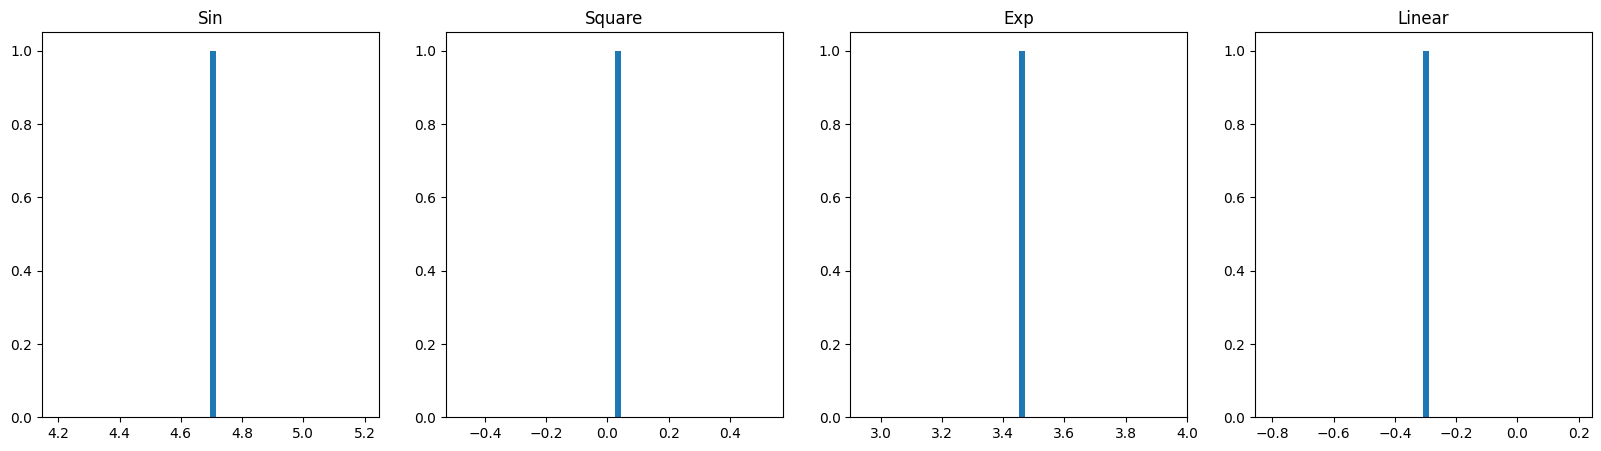

In [45]:
if len(functions) > 1:
    fig, axs = plt.subplots(1, len(function_coef), figsize=(20, 5))
    for i, (key, values) in enumerate(function_coef.items()):
        axs[i].hist(values, bins=50)
        axs[i].set_title(key)
    plt.show()

else:
    fig, axs = plt.subplots(1, 1, figsize=(20, 5))
    axs.hist(weights[1], bins=50)
    axs.set_title("Linear")
    plt.show()

In [46]:
# Find mean and std of all functions:
for key, values in function_coef.items():
    print(f'{key}: {np.mean(values):.3f} +- {np.std(values):.3f}')

Sin: 4.696 +- 0.000
Square: 0.023 +- 0.000
Exp: 3.451 +- 0.000
Linear: -0.307 +- 0.000


In [30]:
models[0].print_expression(functions, var_names=["x"], threshold=0.1)

Matrix([[3.45023*exp(1.0*x) + 4.95539*sin(1.0*x)]])

## Lotka Volterra

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
import ipywidgets as ipw

alpha = 1. #mortality rate due to predators
beta = 1.
delta = 1.
gamma = 1.
x0 = 4.
y0 = 2.

def derivative(X, t, alpha, beta, delta, gamma):
    x, y = X
    dotx = x * (alpha - beta * y)
    doty = y * (-delta + gamma * x)
    return np.array([dotx, doty])

Nt = 500
tmax = 30.
t = np.linspace(0.,tmax, Nt)
X0 = [x0, y0]
res = integrate.odeint(derivative, X0, t, args = (alpha, beta, delta, gamma))
x1, x2 = res.T

x = torch.stack([torch.Tensor(x1), torch.Tensor(x2)], dim=1)

In [222]:
# Approximate derivatives and store them in new torch tensor y
y = torch.zeros((len(x1) - 1, 2))
for i in range(len(x1) - 1):
    y[i, 0] = (x1[i + 1] - x1[i]) / (t[1] - t[0])
    y[i, 1] = (x2[i + 1] - x2[i]) / (t[1] - t[0])


In [223]:
# Caluculate x1dot and x2dot using lotka volterra equation
x1dot = x1 * (alpha - beta * x2)
x2dot = x2 * (-delta + gamma * x1)

In [224]:
# Remove last sample of x
x = x[:-1]

# Parameters
n_models = 1
epochs = 1000
n_samples = 100
input_size = 2
output_size = 2

lr = 0.001
weight_decay = 0.001
depth = 2

functions = [Square(), Linear(), Multiply()]

model = SymbolicNet(input_size=input_size, output_size=output_size, depth=depth, functions=functions, weight_input_x=True)
model.train_n_epochs(x, y, epochs=epochs, lr=lr, weight_decay=weight_decay, verbose=True)

TypeError: train_n_epochs() got an unexpected keyword argument 'weight_decay'

In [225]:
model.print_expression([Square(), Linear()], ["x1", "x2"], threshold=0.3)[1]

IndexError: list index out of range

In [226]:
# Find mean and std of all functions:
for key, values in function_coef.items():
    print(f'{key}: {np.mean(values):.3f} +- {np.std(values):.3f}')

Sin: nan +- nan
Square: nan +- nan
Exp: nan +- nan
Linear: nan +- nan


## Duffing dataset

In [10]:
from duffing_dataset import * 

# Load data
with open("duffing_dataset.pickle", "rb") as file:
    data = pickle.load(file)

In [115]:
x = data.x[:1000]
y = data.y[:1000]

# Parameters
n_models = 10
epochs = 1000
n_samples = 100
input_size = 3
output_size = 2

lr = 0.001
l = 0.001
depth = 1

functions = [Linear(), Linear(), Pow(2), Pow(2), Pow(3), Pow(3)]

models = []
for n in tqdm(range(n_models)):
    model = SymbolicNet(input_size=input_size, output_size=output_size, depth=depth, functions=functions, weight_input_x=True)
    model.train_n_epochs(x, y, epochs=epochs, lr=lr, l=l, regularization="L1", verbose=False)
    models.append(model)


100%|██████████| 10/10 [21:07:42<00:00, 7606.28s/it]  


In [76]:
expression = model.print_expression(functions=functions, var_names=["x1", "x2", "u"], threshold=0)

expressions =[]
for exp, var in zip(expression, ["x1", "x2", "u"]):
    print(f"{var} = {exp}")
    expressions.append(exp)

x1 = 1.00514*x2
x2 = -1.82066*x1**3 + 1.47588*x1 - 0.788726*x2**3 + 0.700415*x2


In [15]:
(np.abs(data.y[:, 0] - data.x[:, 1])).sum()

tensor(134.6915)

In [104]:
y1_pred = data.x_non_norm[200:5200, 0] * 1.00514
y2_pred = -1.82066 * data.x_non_norm[200:5200, 0] ** 3 + 1.47588 * data.x_non_norm[200:5200, 0] - 0.788726 *  data.x_non_norm[200:5200, 1] ** 3 + 0.700415* data.x_non_norm[200:5200, 1]

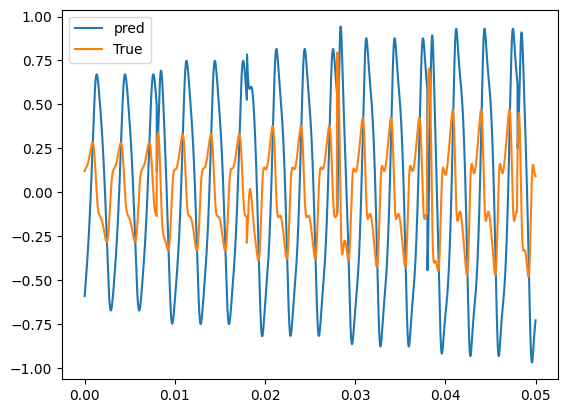

In [105]:
plt.plot(np.linspace(0, data.DT, 5000), y1_pred, label="pred")
plt.plot(np.linspace(0, data.DT, 5000), data.y_non_norm[200:5200, 0], label="True")
plt.legend()

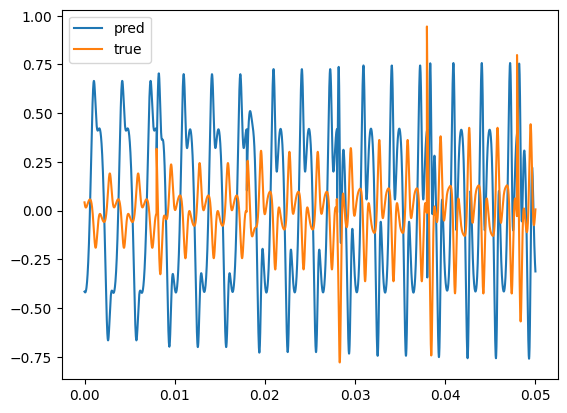

In [108]:
# Se på forskyvelsen!
plt.plot(np.linspace(0, data.DT, 5000), y2_pred, label="pred")
plt.plot(np.linspace(0, data.DT, 5000), data.y_non_norm[200:5200, 1], label="true")
plt.legend()

In [107]:
sym.Symbol("x").evalf

<bound method EvalfMixin.evalf of x>